###### <span style="color: gray ">ライブラリをまとめてインポート</span>

In [1]:
# 数値計算およびデータ分析用ライブラリ
import numpy as np
import pandas as pd

# グラフ描画用ライブラリ
import matplotlib.pyplot as plt

# 統計および信号処理関数用ライブラリ
from scipy import signal
from scipy.signal import savgol_filter

# ハイパースペクトルイメージ処理用ライブラリ
from spectral import imshow
import spectral.io.envi as envi

# 画像解析用ライブラリ
import cv2

# 乱数生成用モジュール
import random

# 機械学習モデルおよび評価関数
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# 画像処理用ライブラリ
from skimage.filters import threshold_otsu

# ディープラーニングフレームワーク
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# データセット
from keras.datasets import cifar10


C:\Users\tetsu\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# <span style="color:RoyalBlue; ">12.2 NIR–HSIデータの構造と読み込み</span>

###### <span style="color: gray ">コード12.1　HSIデータの読み込みとその概要の表示</span>

In [2]:
dark_ref=envi.open("dataChapter12/dark.hdr","dataChapter12/dark.raw")
white_ref=envi.open("dataChapter12/white.hdr","dataChapter12/white.raw")
wood_ref=envi.open("dataChapter12/wood.hdr","dataChapter12/wood.raw")
print(white_ref)
print(wood_ref)

	Data Source:   '.\dataChapter12/white.raw'
	# Rows:              1
	# Samples:         320
	# Bands:           256
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16
	Data Source:   '.\dataChapter12/wood.raw'
	# Rows:            280
	# Samples:         320
	# Bands:           256
	Interleave:        BIL
	Quantization:  16 bits
	Data format:    uint16


C:\Users\tetsu\anaconda3\Lib\site-packages\spectral\io\envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


###### <span style="color: gray ">コード12.2　反射率の計算</span>

In [12]:
# 配列に変換
white=np.array(white_ref.load())
dark=np.array(dark_ref.load())
wood=np.array(wood_ref.load())
# 波長データを抽出
wave =wood_ref.metadata['wavelength']
wave=np.array(wave,dtype=float)
# 反射率の算出
ref_sample=np.divide(np.subtract(wood,dark),np.subtract(white,dark))
print("white",white.shape)
print("dark",dark.shape)
print("wood",wood.shape)
print("反射率",ref_sample.shape)

white (1, 320, 256)
dark (1, 320, 256)
wood (280, 320, 256)
反射率 (280, 320, 256)


C:\Users\tetsu\AppData\Local\Temp\ipykernel_47268\232569068.py:9: RuntimeWarning: invalid value encountered in divide
  ref_sample=np.divide(np.subtract(wood,dark),np.subtract(white,dark))


# <span style="color:RoyalBlue; ">12.3 画像とスペクトルの抽出</span>

###### <span style="color: gray ">コード12.3　任意の波長での画像を出力</span>

In [15]:
def get_image_at_wavelength(sample, waveinf, wavelength):
    """
    Parameters:
    ref_sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    wave (numpy.ndarray): 波長データ (形状: (波長数,))
    wavelength (float): 抽出したい特定の波長

    Returns:
    numpy.ndarray: 指定された波長での画像 (形状: (高さ, 幅))
    """
    # 波長に最も近いインデックスを見つける
    idx = np.argmin(np.abs(waveinf - wavelength))
    # その波長での画像を取得
    image = ref_sample[:, :, idx]
    plt.figure(figsize=(6, 6))
    img = plt.imshow(image, cmap='viridis')
    plt.colorbar(img, orientation='horizontal', shrink=0.8, aspect=40, pad=0.05)
    plt.title(f'Image at {wavelength} nm')
    plt.show()

###### <span style="color: gray ">コード12.4　関数get_image_at_wavelengthの実行</span>

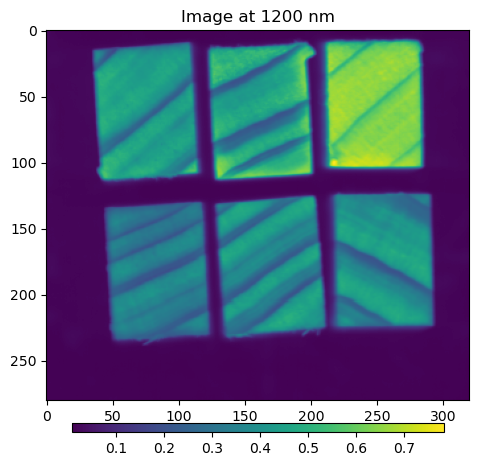

In [16]:
get_image_at_wavelength(ref_sample, wave, 1200)

###### <span style="color: gray ">コード12.5　任意の2箇所のピクセルにおけるスペクトルとスペクトルの積算値の画像の出力</span>

In [17]:
def plot_spectrum_and_sum_image(sample, waveinf, x1, y1, x2, y2):
    """
    Parameters:
    sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    waveinf (numpy.ndarray): 波長データ (形状: (波長数,))
    x1, y1 (int): 1つ目の指定されたピクセルの座標
    x2, y2 (int): 2つ目の指定されたピクセルの座標

    Returns:
    None
    """
    # 特定の位置のスペクトルを取得
    spectrum1 = sample[y1, x1, :]
    spectrum2 = sample[y2, x2, :]

    # スペクトルの波長方向積算値の画像を計算
    sum_image = np.sum(sample, axis=2)
    
    plt.figure(figsize=(8, 8))

    # スペクトルの波長方向積算値の画像を表示
    plt.subplot(2, 1, 1)
    plt.imshow(sum_image, cmap='gray')
    plt.colorbar(label='Sum')
    # 1つ目の位置にピンク色のマークを付ける
    plt.scatter(x1, y1, color='magenta', marker='x')  
    plt.scatter(x2, y2, color='cyan', marker='x')    # 2つ目の位置に水色のマークを付ける
    plt.title('Sum Image')

    # 特定の位置のスペクトルを表示
    plt.subplot(2, 1, 2)
    plt.plot(waveinf, spectrum1, color='magenta', label=f'Spectrum at ({x1}, {y1})')
    plt.plot(waveinf, spectrum2, color='cyan', label=f'Spectrum at ({x2}, {y2})')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title('Spectra at Specified Locations')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 使用例
# plot_spectra_and_sum_image(sample, waveinf, x1, y1, x2, y2)


###### <span style="color: gray ">コード12.6　関数plot_spectrum_and_sum_imageの実行</span>

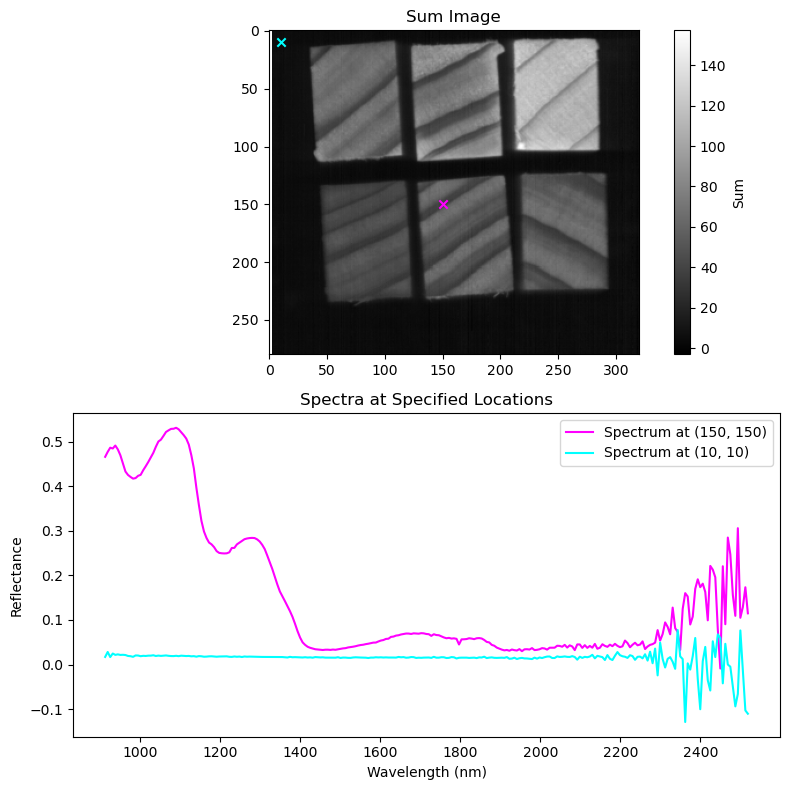

In [18]:
plot_spectrum_and_sum_image(ref_sample, wave, 150,150,10,10)

###### <span style="color: gray ">コード12.7　参照光データ，ダークデータ，試料反射光の表示</span>

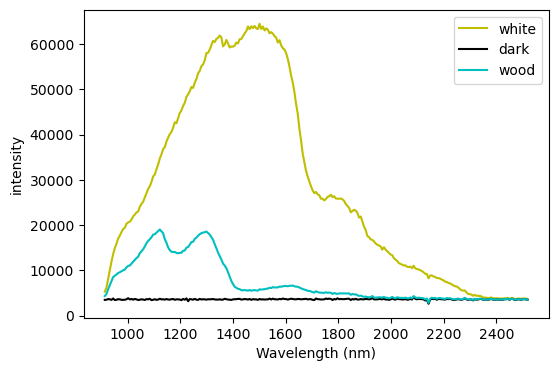

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(wave,white[0,150,:],'y-',label= "white")
plt.plot(wave,dark[0,150,:],'k-',label= "dark")
plt.plot(wave,wood[150,150,:],'c-',label= "wood")
plt.xlabel('Wavelength (nm)')
plt.ylabel('intensity')
plt.legend()

# <span style="color:RoyalBlue; ">12.4 木材試料領域のスペクトルと画像を抽出</span>

## <span style="color: DeepPink; ">12.4.1 任意の波長領域でのHSIとスペクトルの抽出</span>

###### <span style="color: gray ">コード12.8　任意の波長領域における画像とスペクトルの抽出</span>

In [23]:
def extract_image(sample, waveinf, minz, maxz):
    """
    特定の波長範囲での画像データと波長情報を抽出する関数。
    Parameters:
    sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    waveinf (numpy.ndarray): 波長データ (形状: (波長数,))
    minz (float): 抽出する波長範囲の最小値
    maxz (float): 抽出する波長範囲の最大値
    Returns:
    tuple: 抽出された画像データと波長情報 (numpy.ndarray, numpy.ndarray)
    """
    # 指定された波長範囲のインデックスを見つける
    idx1 = np.argmin(np.abs(waveinf - minz))
    # idx2のインデックスを含めるために+1
    idx2 = np.argmin(np.abs(waveinf - maxz)) + 1  

    # 特定の波長範囲での画像データを抽出
    sample_extract = sample[:, :, idx1:idx2]
    # 対応する波長情報を抽出
    wave_extract = waveinf[idx1:idx2]

    return sample_extract, wave_extract

###### <span style="color: gray ">コード12.9　関数extract_imageの実行</span>

In [24]:
sample_extract, wave_extract=extract_image(ref_sample, wave, 950, 2200)

###### <span style="color: gray ">コード12.10　関数plot_spectrum_and_sum_imageの実行（抽出後）</span>

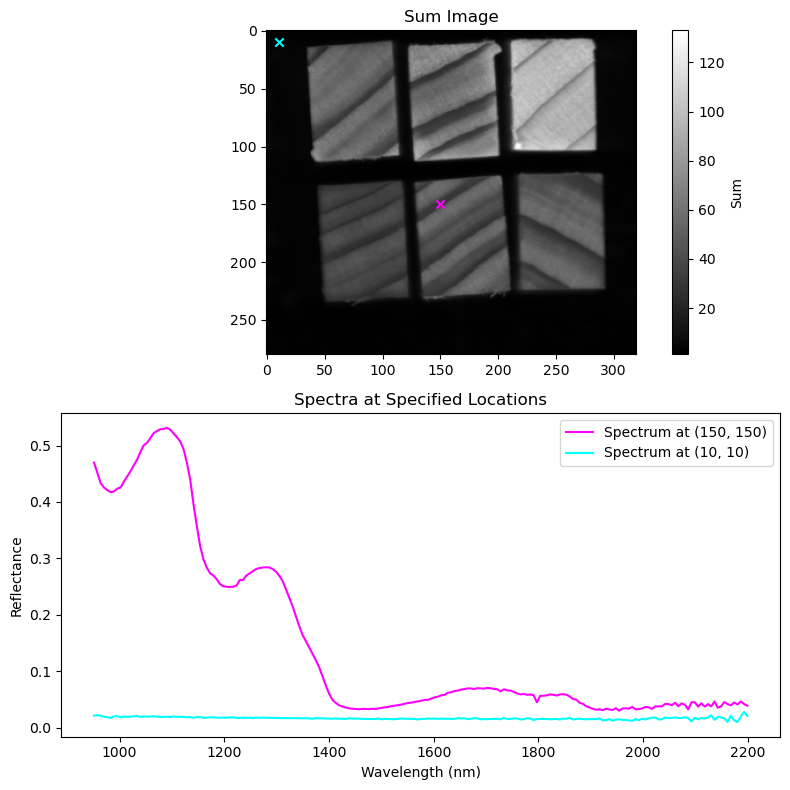

In [22]:
plot_spectrum_and_sum_image(sample_extract, wave_extract, 150,150,10,10)

## <span style="color: DeepPink; ">12.4.2 試料領域の抽出</span>

###### <span style="color: gray ">コード12.11　1つの波長とPCAスコアによる領域の判別</span>

In [27]:
def extract_sample_region(sample, waveinf, wavelength):
    """
    パラメーター:
    sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    waveinf (numpy.ndarray): 波長情報 (形状: (波長数,))
    wavelength (float): 抽出する特定の波長
    戻り値:
    None
    """
    # ①wavelengthで指定される波長での画像を抽出
    # ①-1指定された波長に最も近いインデックスを見つける
    idx = np.argmin(np.abs(waveinf - wavelength))
    # ①-2指定された波長での画像を抽出
    image = sample[:, :, idx]
    # ②PCAスコアの画像を作成
    # ②-1 Reshapeで3次元データのsampleを（高さ×幅, 波長数）の二次元データに展開する
    reshaped_sample = sample.reshape((-1, sample.shape[2]))
    # ②-2PCAを実行し、第1－第3主成分スコア主成分スコアを計算
    pca = PCA(n_components=3)
    pca_scores = pca.fit_transform(reshaped_sample)
    # ②-3Reshapeでサイズを(y,x,3)の3次元データに戻す
    pc_images = pca_scores.reshape((sample.shape[0], sample.shape[1], 3))

    # ③大津の二値化法を使用して二値化画像を作成(木材部が1、背景部が0)
    binary_image = (image > threshold_otsu(image)).astype(int)
    pc1_binary = (pc_images[:, :, 0] > threshold_otsu(pc_images[:, :, 0])).astype(int)
    pc2_binary = (pc_images[:, :, 1] > threshold_otsu(pc_images[:, :, 1])).astype(int)
    pc3_binary = (pc_images[:, :, 2] > threshold_otsu(pc_images[:, :, 2])).astype(int)
    
    # 画像を表示
    plt.figure(figsize=(12, 9))
    plt.subplot(3, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image at {wavelength} nm')
    plt.subplot(3, 4, 5)
    plt.imshow(binary_image, cmap='gray')
    plt.title('binary image')
    plt.subplot(3, 4, 2)
    plt.imshow(pc_images[:, :, 0], cmap='gray')
    plt.title('PC1 score image')
    plt.subplot(3, 4, 6)
    plt.imshow(pc1_binary, cmap='gray')
    plt.title('PC1 binary image')
    plt.subplot(3, 4, 10)
    plt.plot(pca.components_[0])
    plt.title('PC1 loading')
    plt.subplot(3, 4, 3)
    plt.imshow(pc_images[:, :, 1], cmap='gray')
    plt.title('PC2 score image')
    plt.subplot(3, 4, 7)
    plt.imshow(pc2_binary, cmap='gray')
    plt.title('PC2 binary image')
    plt.subplot(3, 4, 11)
    plt.plot(pca.components_[1])
    plt.title('PC2 loading')
    plt.subplot(3, 4, 4)
    plt.imshow(pc_images[:, :, 2], cmap='gray')
    plt.title('PC3 score image')
    plt.subplot(3, 4, 8)
    plt.imshow(pc3_binary, cmap='gray')
    plt.title('PC3 binary image')
    plt.subplot(3, 4, 12)
    plt.plot(pca.components_[2])
    plt.title('PC3 loading')
    plt.tight_layout()
    plt.show()
    
    return binary_image,pc1_binary,pc2_binary,pc3_binary

###### <span style="color: gray ">コード12.12　関数extract_sample_regionの実行</span>

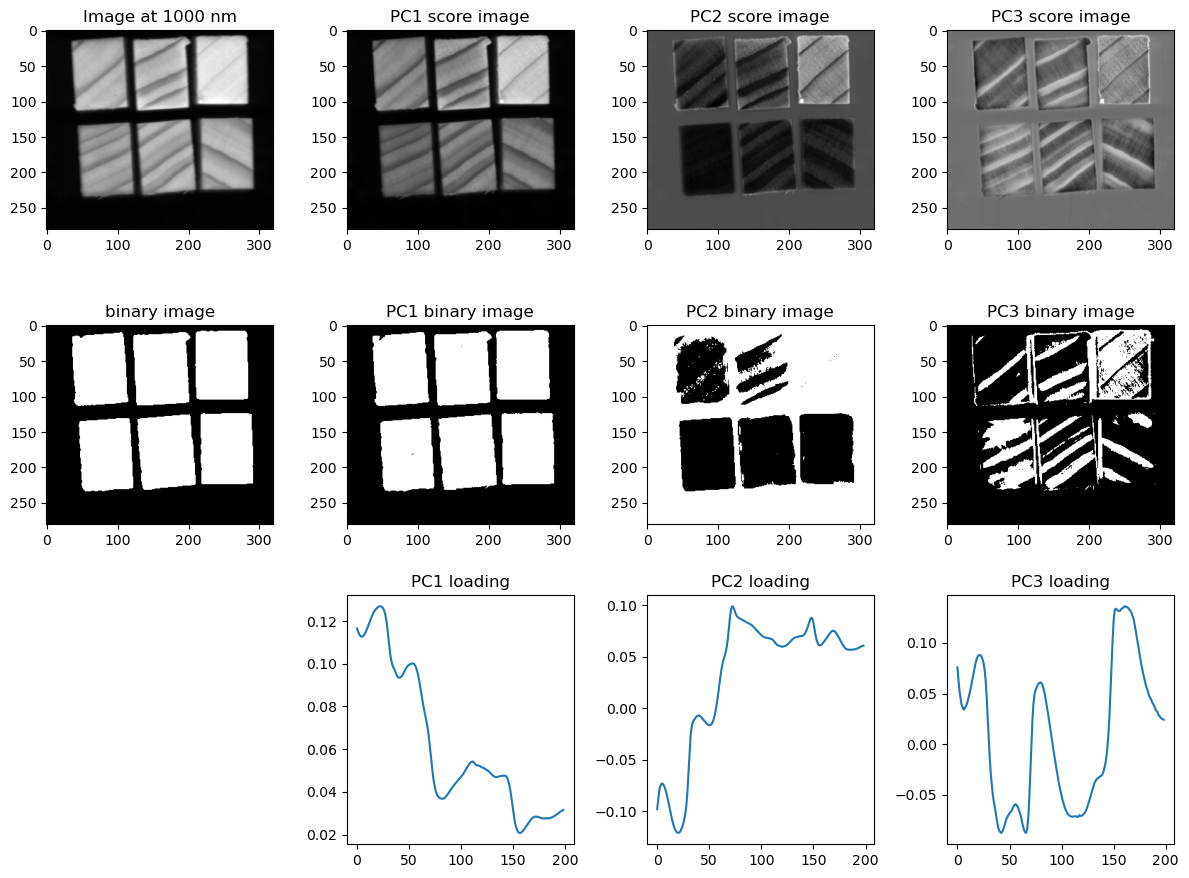

In [28]:
binary_image,pc1_binary,pc2_binary,pc3_binary=extract_sample_region(sample_extract, wave_extract,1000)

###### <span style="color: gray ">コード12.13　関数connectedComponentsWithStatsの実行</span>

In [29]:
# retval, labels, stats, centroids = cv2.connectedComponentsWithStats(image)

###### <span style="color: gray ">コード12.14　二値化画像をもとに，特定の領域へのラベル番号の割り当て</span>

In [32]:
def analyze_binary_image(sample, waveinf, binary_im):
    """
    Parameters:
    sample (numpy.ndarray): HSIデータ (形状: (高さ, 幅, 波長数))
    waveinf (numpy.ndarray): 波長データ (形状: (波長数,))
    binary_image (numpy.ndarray): バイナリ画像 (形状: (高さ, 幅))
    Returns:
    None
    """
    # ①反射率を積算した画像を作成
    sum_image = np.sum(sample, axis=2)
    binary_im = (binary_im * 255).astype(np.uint8)

    # ②connectedComponentsWithStatsで連結成分を解析
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_im)
    # 画像を表示
    plt.figure(figsize=(6, 6))
    #③connectedComponentsWithStatsの結果をマーク
    marked_image = sum_image.copy()
    for i in range(1, num_labels):  # 背景をスキップ
        print(f'{i}番目の情報は{stats[i]}です')
        marked_image[labels == i] = 100
        x, y = int(centroids[i][0]), int(centroids[i][1])
        cv2.putText(marked_image, str(i), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    
    plt.imshow(marked_image, cmap='magma')
    plt.title('connectedComponentsWithStats')

    plt.tight_layout()
    plt.show()
    return num_labels, labels, stats, centroids

###### <span style="color: gray ">コード12.15　関数analyze_binary_imageの実行</span>

1番目の情報は[ 210    8   75   97 7074]です
2番目の情報は[  37   10   79  104 7270]です
3番目の情報は[ 123   10   81  103 7440]です
4番目の情報は[ 218  124   74  100 7239]です
5番目の情報は[ 129  126   82  106 7584]です
6番目の情報は[  46  131   77  103 7187]です


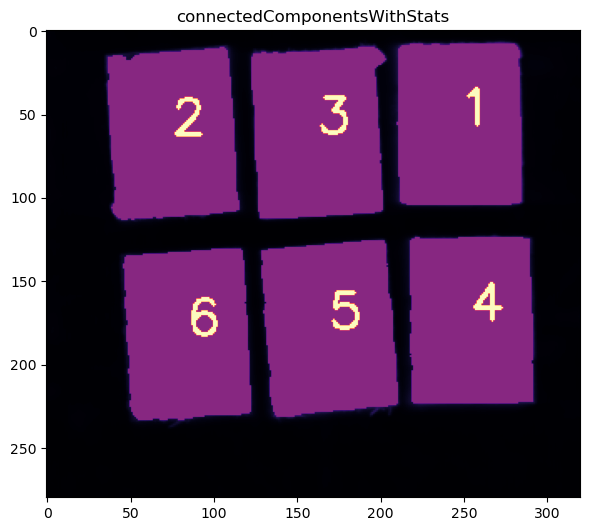

In [33]:
num_labels, labels, stats, centroids=analyze_binary_image(sample_extract, wave_extract, binary_image)

# <span style="color:RoyalBlue; ">12.5 PLS回帰を用いた予測値の空間分布の可視化</span>

###### <span style="color: gray ">コード12.16　含水率のデータの読み込み</span>

In [34]:
#含水率データを読み込み
mc=pd.read_csv('dataChapter12/HSI_mc.csv') 
mc=mc.rename(columns={'Unnamed: 0':''})
mc=mc.set_index('')
print(mc)

           mc
             
1    9.808280
2   65.889571
3   96.082474
4  104.445664
5   92.848572
6  120.367111


###### <span style="color: gray ">コード12.17　各木材試料の平均スペクトルの計算</span>

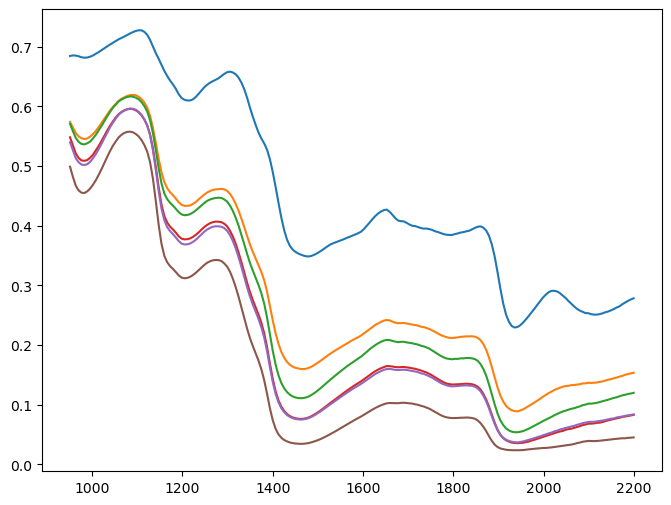

In [35]:
average_spectra = []  # 空のリストを用意して、平均スペクトルを格納。
sample_order = [1, 3, 2, 4, 5, 6]  #①サンプルの順序を指定。

# 各ラベルに対して処理を行う。
for label in sample_order:  
    indices = np.where(labels == label)  #②ラベルに該当するピクセルのインデックスを取得。
    component_spectra = sample_extract[indices[0], indices[1], :]  #③対応するスペクトルを抽出。
    avg_spectrum = np.mean(component_spectra, axis=0)  #④平均スペクトルを計算。
    average_spectra.append(avg_spectrum)  # リストに平均スペクトルを追加。

average_spectra = np.array(average_spectra)  # リストをNumPy配列に変換。

# 平均スペクトルをプロット。
plt.figure(figsize=(8, 6))
plt.plot(wave_extract, average_spectra.T)

###### <span style="color: gray ">コード12.18　PLS回帰によるスペクトル解析と予測値の空間分布の可視化</span>

In [38]:
def analyze_spectra(sample, waveinf, labelsin, sample_order, prop, n_components, filter_size=0, vmin=None, vmax=None):
    """
    引数:
    spectra (numpy.ndarray): 反射率データ (形状: (y, x, 波長数))
    waveinf (numpy.ndarray): 波長情報 (形状: (波長数,))
    labelsin (numpy.ndarray): 試料領域情報 (形状: (y, x))
    sample_order (list): 試料領域の順序
    prop (numpy.ndarray): PLS回帰の目的変数
    n_components (int): PLS回帰の成分数
    filter_size (int): ガウシアンフィルタのサイズ (デフォルト: 0, フィルタリングなし)
    vmin (float): 予測プロパティマップの最小値 (オプション)
    vmax (float): 予測プロパティマップの最大値 (オプション)

    戻り値:
    numpy.ndarray: 各領域の平均スペクトル
    """
    # 平均スペクトルを計算
    average_spectra = []
    for label in sample_order:
        indices = np.where(labelsin == label)
        component_spectra = sample[indices[0], indices[1], :]
        avg_spectrum = np.mean(component_spectra, axis=0)
        average_spectra.append(avg_spectrum)
    average_spectra = np.array(average_spectra)

    # 平均スペクトルをプロット
    plt.figure(figsize=(8, 6))
    plt.plot(waveinf, average_spectra.T)
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.title('Average Spectra')
    plt.show()

    # 指定した成分数でPLS回帰を実行
    plsr = PLSRegression(n_components=n_components)
    plsr.fit(average_spectra, prop)
    prop_pred = plsr.predict(average_spectra)
    r2 = r2_score(prop, prop_pred)
    mse = mean_squared_error(prop, prop_pred)
    print(f"R2: {r2}")
    print(f"MSE: {mse}")

    # 実測値と予測値の散布図を表示
    plt.figure(figsize=(8, 6))
    plt.scatter(prop, prop_pred, alpha=0.7, color='blue')
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(f'Measured vs. Predicted (R2: {r2:.2f}, MSE: {mse:.2f})')
    plt.show()

    # 回帰係数スペクトルを表示
    plt.figure(figsize=(8, 6))
    plt.plot(waveinf, plsr.coef_.flatten())
    plt.xlabel('Wavelength')
    plt.ylabel('Regression Coefficient')
    plt.title('Regression Coefficient Spectrum')
    plt.show()

    # ①spectraの各ピクセルに対してPLSモデルを適用
    # ①-1要素がすべて0の行列を作成。
    predicted_spectra = np.zeros_like(sample[:, :, 0])
    for label in sample_order:
        indices = np.where(labelsin == label) # ①-2ラベルに該当するピクセルのインデックスを取得。
        predicted_spectra[indices] = plsr.predict(sample[indices[0], indices[1], :]).flatten() # ①-3各ピクセルでPLS予測

    # ②予測結果をガウシアンフィルタでぼかす (filter_size > 0 の場合)
    if filter_size > 0:
        predicted_spectra = cv2.GaussianBlur(predicted_spectra,(filter_size,filter_size),0)
     # 予測結果を表示
    plt.figure(figsize=(8, 6))
    plt.imshow(predicted_spectra, cmap='jet',vmin=vmin, vmax=vmax)
    plt.colorbar(label='Predicted Property')
    plt.title('Predicted Property Map')
    plt.show()

###### <span style="color: gray ">コード12.19　関数analyze_spectraの実行</span>

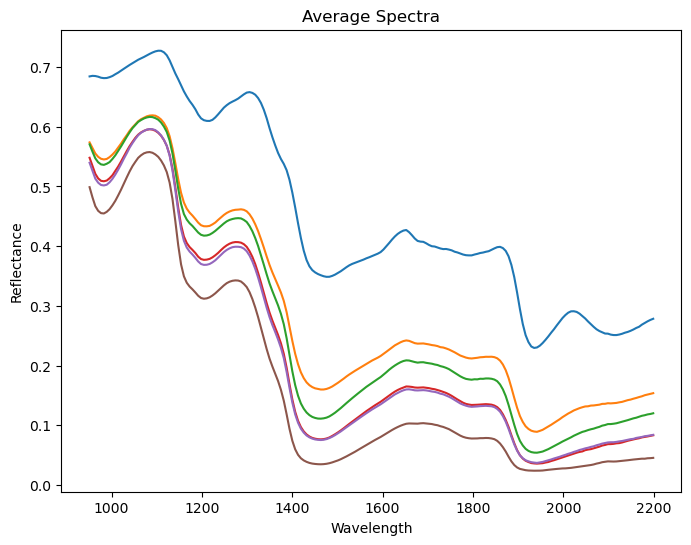

R2: 0.9788960207929477
MSE: 27.301339112674487


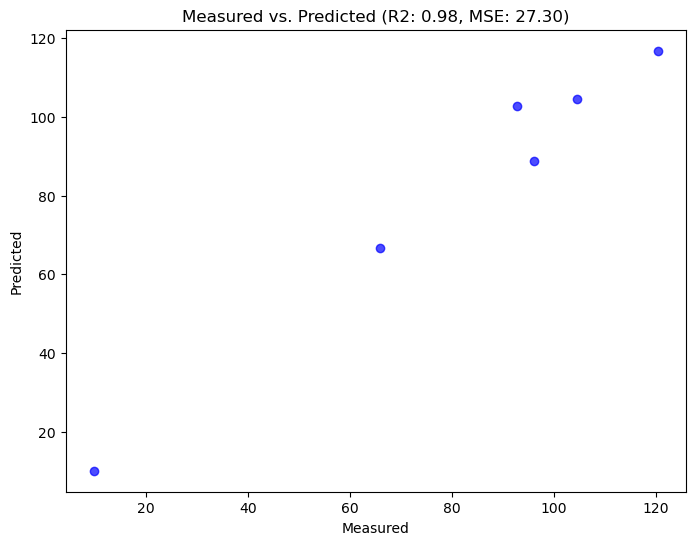

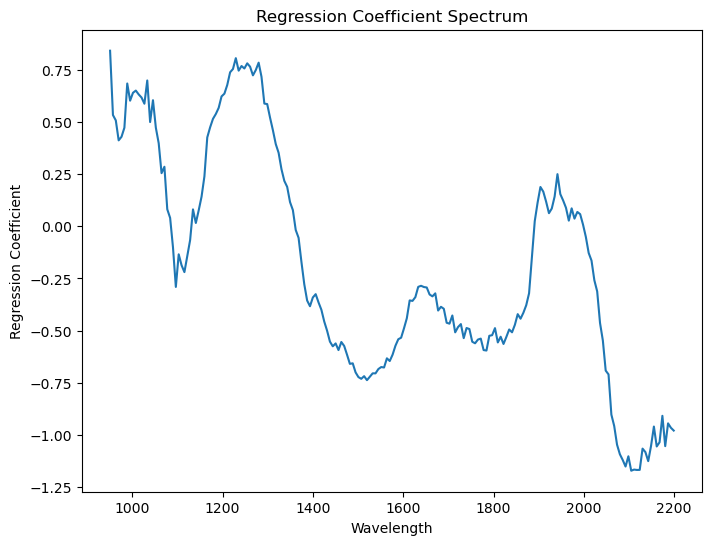

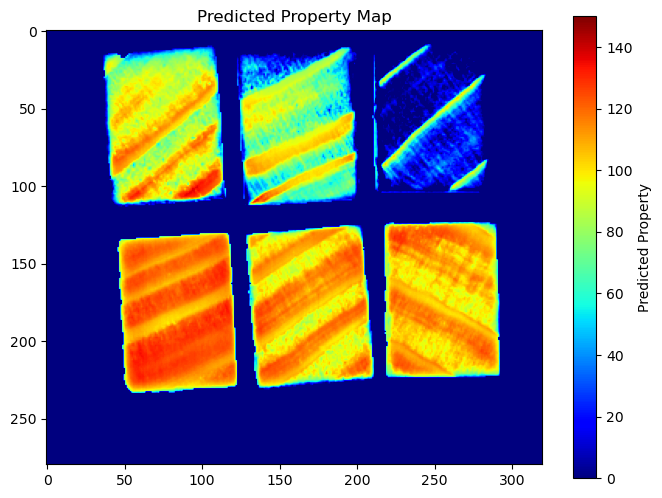

In [39]:
analyze_spectra(sample_extract, wave_extract, labels, [1,3,2,4,5,6],mc,3,1,0,150)

# <span style="color:RoyalBlue; ">12.6 HSIデータ解析への畳み込みニューラルネットワーク（CNN）の適用</span>

###### <span style="color: gray ">コード12.20　PCAによる化学成分の空間分布の可視化</span>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


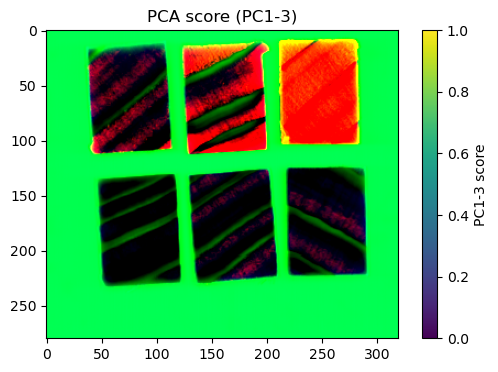

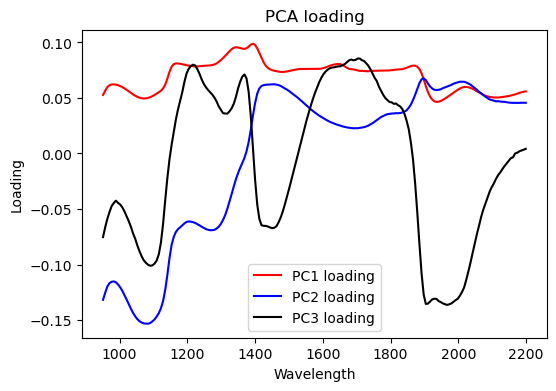

In [40]:
# ラベルが指定された領域からすべてのスペクトルを抽出
wood_spectra = sample_extract[labels > 0]  # ①ラベルが0より大きい領域からスペクトルを抽出

# ②抽出したスペクトルでPCAを実行
pca = PCA(n_components=3)  # 3つの成分でPCAを初期化
pca.fit(wood_spectra)  # 抽出したスペクトルでPCAを適用

# ③PCAモデルを使用してデータセット全体を変換
reshaped_sample = sample_extract.reshape(-1, sample_extract.shape[2])  # PCA変換のために形状を変更
pca_scores = pca.transform(reshaped_sample)  # データを変換
full_pca_scores = pca_scores.reshape(sample_extract.shape[0], sample_extract.shape[1], 3)  # 元の形状に戻す

# 最初の3つの成分のPCAスコアをプロット
plt.figure(figsize=(6, 4))
plt.imshow(full_pca_scores)
plt.colorbar(label='PC1-3 score')
plt.title('PCA score (PC1-3)')
plt.show()

# PC1からPC3までのローディングを表示
plt.figure(figsize=(6, 4))
plt.plot(wave_extract, pca.components_[0], label='PC1 loading', color='red')  # PC1のローディングをプロット
plt.plot(wave_extract, pca.components_[1], label='PC2 loading', color='blue')  # PC2のローディングをプロット
plt.plot(wave_extract, pca.components_[2], label='PC3 loading', color='black')  # PC3のローディングをプロット
plt.xlabel('Wavelength')
plt.ylabel('Loading')
plt.title('PCA loading')
plt.legend()
plt.show()


###### <span style="color: gray ">コード12.21　各試料のピクセルを抽出</span>

In [42]:
A6=full_pca_scores[120:240,37:127,:]
A5=full_pca_scores[120:240,125:215,:]
A4=full_pca_scores[120:240,213:303,:]
A3=full_pca_scores[0:120,30:120,:]
A2=full_pca_scores[0:120,120:210,:]
A1=full_pca_scores[0:120,205:295,:]

###### <span style="color: gray ">コード12.22　CNNモデルの定義とCNNを用いた含水率の予測</span>

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 118, 88, 32)       896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 59, 44, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 57, 42, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 28, 21, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 26, 19, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 31616)            

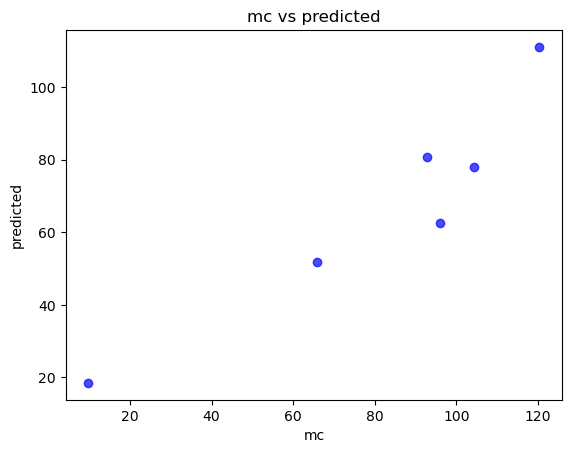

R2: 0.70
RMSE: 19.66


In [46]:
images = np.array([A1, A2, A3, A4, A5, A6])  # 画像データをNumPy配列に格納
mc = np.array(mc)  # 含水率データをNumPy配列に格納

# ①CNNモデルの定義
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(120, 90, 3)),  # 畳み込み層
    MaxPooling2D((2, 2)),  # プーリング層
    Conv2D(64, (3, 3), activation='relu'),  # 畳み込み層
    MaxPooling2D((2, 2)),  # プーリング層
    Conv2D(64, (3, 3), activation='relu'),  # 畳み込み層
    Flatten(),  # 平坦化層
    Dense(64, activation='relu'),  # 全結合層
    Dense(1)  # 出力層
])

# ②モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error')  # 最適化アルゴリズムと損失関数の設定
model.summary()  # ③モデルの構造を表示
# モデルの学習
model.fit(images, mc, epochs=10)  #④画像データと含水率データでモデルを学習

# 含水率の予測
mc_pred = model.predict(images).flatten()  #⑤画像データから含水率を予測

# 予測値と実測値の散布図のプロット
plt.scatter(mc, mc_pred, alpha=0.7, color='blue')
plt.xlabel('mc')
plt.ylabel('predicted')
plt.title('mc vs predicted')
plt.show()

# R2とMSEの計算
r2 = r2_score(mc, mc_pred)  # 決定係数R2の計算
mse = mean_squared_error(mc, mc_pred)  # 平均二乗誤差MSEの計算
rmse=np.sqrt(mse)
print(f'R2: {r2:.2f}')
print(f'RMSE: {rmse:.2f}')


## <span style="color: DeepPink; "> appendix opencvによるコインの検出</span>

###### <span style="color: gray ">コード12.23　画像からコインを検出する</span>

検出されたコイン数：4個
contour: 0, size: 13018.0, centroid: (90.85, 344.84)
contour: 1, size: 9145.0, centroid: (90.30, 174.22)
contour: 2, size: 8212.5, centroid: (245.94, 130.63)
contour: 3, size: 8210.0, centroid: (337.12, 61.76)


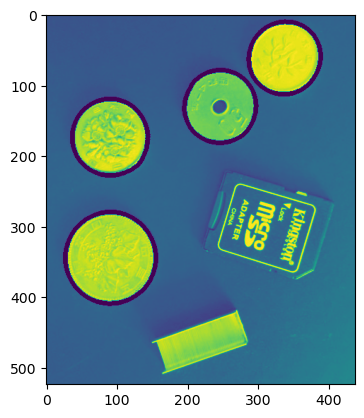

In [26]:
# ファイルを読み込み グレースケール化
img = cv2.imread("dataChapter8/coin.jpg", cv2.IMREAD_GRAYSCALE)
# 二値化
_, threshold = cv2.threshold(img, 160, 255, cv2.THRESH_BINARY)
# 輪郭を抽出
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE ) 
# 微小な輪郭を削除
contours2 = list(filter(lambda x: cv2.contourArea(x) >= 100, contours))
# 円以外を除去したい
contours3 = []
for cnt in contours2:
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    # 輪郭線の近似
    approx = cv2.approxPolyDP(cnt, 0.01 * arclen, True)
# 　　八角形以上を円とみなしてcontours3に格納
    if len(approx)>8:
        contours3.append(cnt)
# 結果表示
print(f"検出されたコイン数：{len(contours3)}個")
for i, cnt in enumerate(contours3):
    # 輪郭の面積を計算する。
    area = cv2.contourArea(cnt)
    # 輪郭のモーメントを計算する。
    M = cv2.moments(cnt)
    # モーメントから重心を計算する。
    cx = M["m10"] / M["m00"]
    cy = M["m01"] / M["m00"]
    print(f"contour: {i}, size: {area}, centroid: ({cx:.2f}, {cy:.2f})")

cv2.drawContours(img, contours3, -1,2,5)
plt.imshow(img)